In [42]:
import matplotlib.pyplot as plt
import torch
import torchio as tio
import numpy as np

In [43]:
p = "/home/msst/Documents/medtech/HeadData/test/new_CTA"
subject_dict = {'head': tio.ScalarImage(p + '/head.nii.gz'),
                'vessels': tio.LabelMap(p + '/vessels.nii.gz'),
                "sample_name" : "new_CTA"}
                #'brain': tio.LabelMap(p + '/brain.nii.gz')}
subject = tio.Subject(subject_dict)

In [44]:
def add_prob_map(subject, focus=1.5):
    _, h, w, d = subject.shape
    x0 = h//2
    y0 = w//2
    prob_slice = np.ones((h,w))
    
    for x in range(prob_slice.shape[0]):
        for y in range(prob_slice.shape[1]):
            prob_slice[x, y] = ((focus-((x/x0-1)**2 + (y/y0-1)**2)**0.5))

    prob_slice = prob_slice.clip(0, 1)
    prob_vol = np.stack(d*[prob_slice,], axis=2)
    #prob_vol = torch.tensor(prob_slice).unsqueeze(2)
    
    prob_Image = tio.Image(tensor=torch.tensor(prob_vol).unsqueeze(0), type=tio.SAMPLING_MAP, affine=subject.head.affine)
    subject.add_image(prob_Image, "prob_map")
    return(subject)


def print_img(vol, axis, title= 'title', show_slice=None, cmap='hot'):
    global SHOW_SLICE
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, show_slice], cmap=cmap)
    plt.colorbar(im)
    

def plot_batch(sampler, size=5):
    queue = tio.Queue(dataset, max_queue_length, patches_per_volume, sampler)
    loader = torch.utils.data.DataLoader(queue, batch_size=size*size)
    for batch in loader:
        fig, axes = plt.subplots(size, size, figsize=(12, 10))
        for ax, im in zip(axes.flatten(), batch["head"]['data']):
            ax.imshow(im.squeeze(), cmap='gray')
        plt.suptitle(sampler.__class__.__name__)
        plt.tight_layout()
        break

In [45]:
add_prob_map(subject, focus=1.1)

Subject(Keys: ('head', 'vessels', 'sample_name', 'prob_map'); images: 3)

In [46]:
subject.shape

(1, 512, 512, 256)

In [47]:
subject.prob_map.data.shape

torch.Size([1, 512, 512, 256])

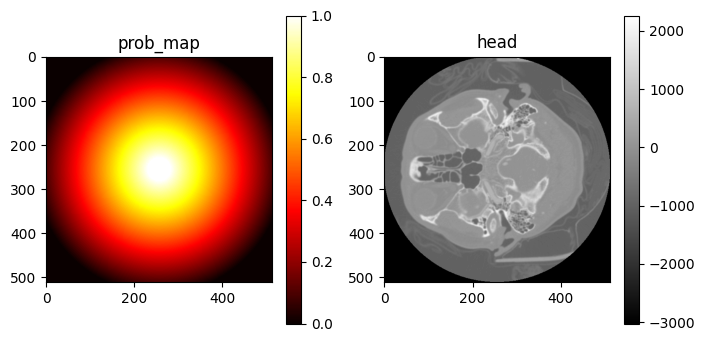

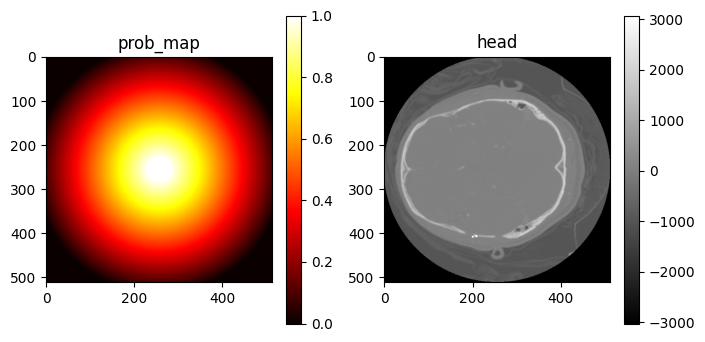

In [48]:
for i in range(40, 140, 50):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
    print_img(subject.prob_map.data[0], ax[0], title='prob_map', show_slice=i, cmap='hot')
    print_img(subject.head.data[0], ax[1], title='head', show_slice=i, cmap='gray')

In [49]:
torch.manual_seed(0)
size = 10
max_queue_length = size*size
patches_per_volume = size*size
subjects = 1 * [subject]
transform = tio.Compose(
    (
        tio.RandomFlip(),
        tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=10)
    )
)
dataset = tio.SubjectsDataset(subjects, transform=transform)
patch_size = (64, 64, 1)  # 2D slices

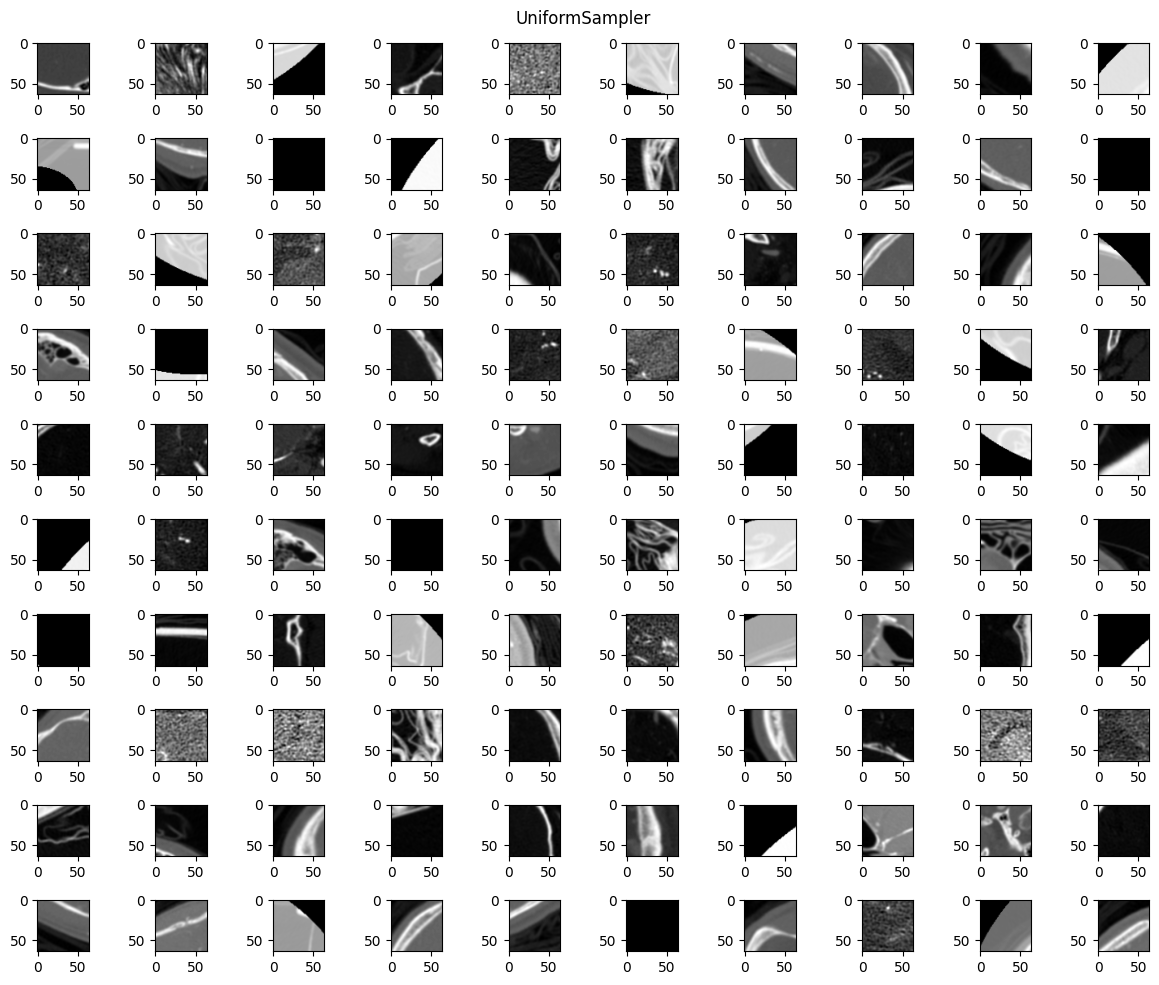

In [50]:
sampler = tio.UniformSampler(patch_size)
plot_batch(sampler, size)

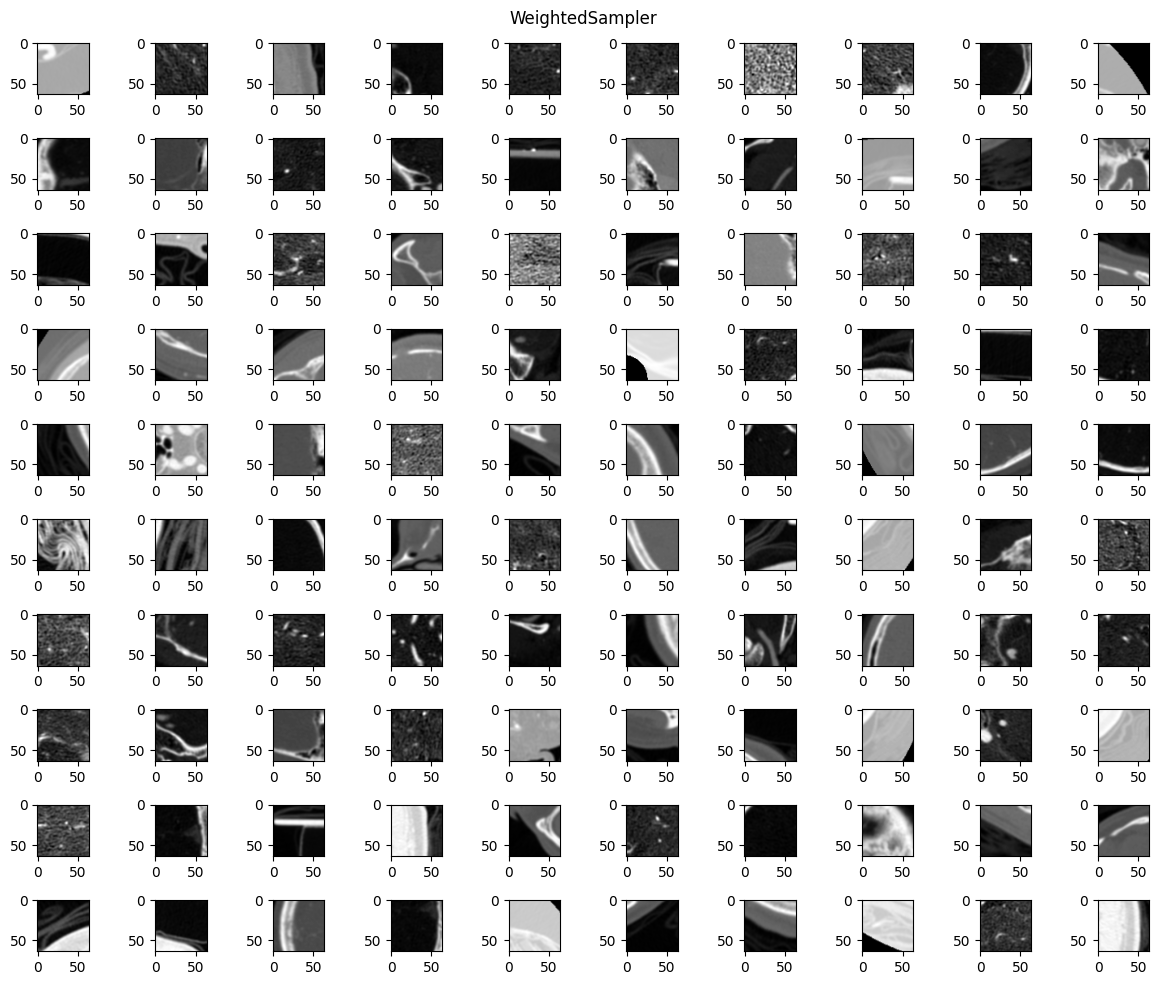

In [51]:
sampler = tio.WeightedSampler(patch_size, probability_map='prob_map')
plot_batch(sampler, size)
plt.show()